### Section 2 part 2 of EDA
#### Weather Forecast variables.
* This is a continuation of exploratory data analysis, more specifically targeted on weather forecast variables.

In [3]:
# import package
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import os

from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport

In [ ]:
"""
https://open-meteo.com/en/docs?hourly=temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,surface_pressure&location_mode=csv_coordinates&csv_coordinates=34.0522,+-118.2437%29,++%0A38.5816,+-21.4944%29,+++%0A42.3314,+-83.0458%29,+++%0A29.7604,+-95.3698%29,+++%0A41.4993,+-81.6944%29,+++%0A41.8781,+-87.6298%29%0A&time_mode=time_interval&start_date=2025-11-07&end_date=2026-01-05. While these model-derived estimates provide consistent temporal coverage, they may underrepresent localized weather variability and are subject to model biases and limited seasonal scope.
"""
# load data
df = pd.read_csv("../datasets/weather_df.csv")

### 2.1 Data Overview

In [5]:
# Loading the dataset
df = pd.read_csv("../datasets/weather_df.csv")
df.shape

(8640, 10)

In [6]:
# Brief view of column names
df.head(3)

,date,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,surface_pressure,city,country,lat,lon
0,2025-11-07 00:00:00+00:00,18.7575,77.0,0.0,6.696387,1006.03955,Los Angeles,US,34.0522,-118.2437
1,2025-11-07 01:00:00+00:00,17.6075,84.0,0.0,5.116561,1006.09620,Los Angeles,US,34.0522,-118.2437
2,2025-11-07 02:00:00+00:00,16.7575,89.0,0.0,2.811690,1005.86676,Los Angeles,US,34.0522,-118.2437


### 2.1 a) Variable Definitions  
#### Meteorological (Weather) Data Dictionary

**Data source:** Open-Meteo Weather API  
https://open-meteo.com/en/docs

#### Core Weather Variables

- **Air Temperature (2 m)**  
  **Variable:** `temperature_2m` | **Unit:** °C  
  Ambient air temperature at 2 m above ground (meteorological standard). Influences atmospheric chemistry, pollutant formation (e.g. ozone), and human thermal comfort.

- **Relative Humidity (2 m)**  
  **Variable:** `relative_humidity_2m` | **Unit:** %  
  Ratio of actual to maximum water vapor content at a given temperature. Affects particulate growth (PM hygroscopicity), visibility, and secondary aerosol formation.

- **Precipitation**  
  **Variable:** `precipitation` | **Unit:** mm (hourly sum)  
  Total rainfall/snowfall accumulated over the preceding hour. Acts as an atmospheric cleansing mechanism via wet deposition, often reducing pollutant concentrations.

- **Wind Speed (10 m)**  
  **Variable:** `wind_speed_10m` | **Unit:** km/h  
  Horizontal wind speed at 10 m above ground (standard reference height). Controls pollutant dispersion, transport, and accumulation under low-wind conditions.

- **Surface Pressure**  
  **Variable:** `surface_pressure` | **Unit:** hPa  
  Atmospheric pressure at the Earth’s surface. Indicates air mass stability and inversion potential, which can trap pollutants near ground level.

#### Geographic Metadata
- **city:** Urban area of measurement  
- **country:** Country of measurement  
- **lat / lon:** Latitude and longitude (decimal degrees)

#### Measurement Characteristics & Limitations
- **Temporal resolution:** Hourly  
- **Data type:** Model-derived (numerical weather prediction, not in-situ sensors)  
- **Spatial resolution:** ~25–30 km grid  
- **Uncertainty sources:** Terrain smoothing, urban heat island under-representation, short temporal coverage

#### Relevance to Air Quality Analysis
Meteorological variables strongly modulate air pollutant concentrations by influencing chemical reactions (temperature), particulate behaviour (humidity), dispersion (wind), removal processes (precipitation), and atmospheric stability (pressure).

---
*Source: Open-Meteo Weather Forecast API Documentation, WHO Air Quality Guidelines, US EPA NAAQS*

### 2.1.2 (b Missing Values Check

In [9]:
# Summary statistics
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,8640,1440,2026-01-05 07:00:00+00:00,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temperature_2m,8640.0,NaN,NaN,NaN,8.336306,9.690101,-19.414,0.083,9.45625,16.502625,30.5105
relative_humidity_2m,8640.0,NaN,NaN,NaN,73.975116,15.684091,13.0,65.0,76.0,86.0,100.0
precipitation,8640.0,NaN,NaN,NaN,0.083831,0.548176,0.0,0.0,0.0,0.0,20.7
wind_speed_10m,8640.0,NaN,NaN,NaN,15.519923,11.528648,0.0,6.989936,11.874544,20.631015,69.48093
surface_pressure,8640.0,NaN,NaN,NaN,1001.886787,14.706314,962.2559,990.411485,1002.347965,1013.3023,1033.2
city,8640,6,Los Angeles,1440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,8640,1,US,8640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,8640.0,NaN,NaN,NaN,38.017167,4.65248,29.7604,34.0522,40.04045,41.8781,42.3314
lon,8640.0,NaN,NaN,NaN,-97.912983,16.154926,-121.4944,-118.2437,-91.4998,-83.0458,-81.6944


#### Insights
* Right-Skewed Variables are precipitation and wind speed, Left-Skewed Variables (temperature, humidity) and Symmetric Variables (pressure).
* The dataset shows excellent completeness with diverse meteorological conditions that create both pollution accumulation risks (calm winds, dry periods) and cleansing opportunities (occasional variable winds).

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  8640 non-null   object 
 1   temperature_2m        8640 non-null   float64
 2   relative_humidity_2m  8640 non-null   float64
 3   precipitation         8640 non-null   float64
 4   wind_speed_10m        8640 non-null   float64
 5   surface_pressure      8640 non-null   float64
 6   city                  8640 non-null   object 
 7   country               8640 non-null   object 
 8   lat                   8640 non-null   float64
 9   lon                   8640 non-null   float64
dtypes: float64(7), object(3)
memory usage: 675.1+ KB


In [11]:
df.nunique().sort_values()

country                    1
city                       6
lon                        6
lat                        6
precipitation             65
relative_humidity_2m      87
date                    1440
wind_speed_10m          2552
temperature_2m          2682
surface_pressure        7417
dtype: int64

In [13]:
# Printing every distinct value in all columns
for column in df.columns:
    print(f"column: {column}", df[column].unique())

column: date ['2025-11-07 00:00:00+00:00' '2025-11-07 01:00:00+00:00'
 '2025-11-07 02:00:00+00:00' ... '2026-01-05 21:00:00+00:00'
 '2026-01-05 22:00:00+00:00' '2026-01-05 23:00:00+00:00']
column: temperature_2m [18.7575    17.6075    16.7575    ... -4.914     -5.2139997  3.636    ]
column: relative_humidity_2m [ 77.  84.  89.  92.  95.  96.  99. 100.  97.  94.  91.  78.  71.  59.
  60.  63.  66.  72.  83.  87.  82.  90.  76.  67.  65.  68.  81.  93.
  98.  85.  74.  48.  38.  34.  30.  26.  22.  19.  17.  23.  28.  31.
  45.  56.  88.  55.  53.  70.  86.  64.  73.  80.  75.  69.  57.  47.
  36.  42.  79.  61.  58.  54.  40.  52.  49.  62.  41.  37.  51.  44.
  27.  39.  50.  16.  21.  35.  32.  20.  29.  46.  24.  33.  18.  14.
  43.  25.  13.]
column: precipitation [ 0.          0.3         0.1         0.5         0.70000005  1.
  2.2         0.4         1.5         1.2         1.4         1.1
  2.4         2.9         3.8         0.2        16.5         7.8
  2.6999998   2.5        

#### Insights:
No evidence of: Unit inconsistency, Type mismatch and Impossible values

#### 2.1.3 Numeric EDA
Exploring distributions and basic signals

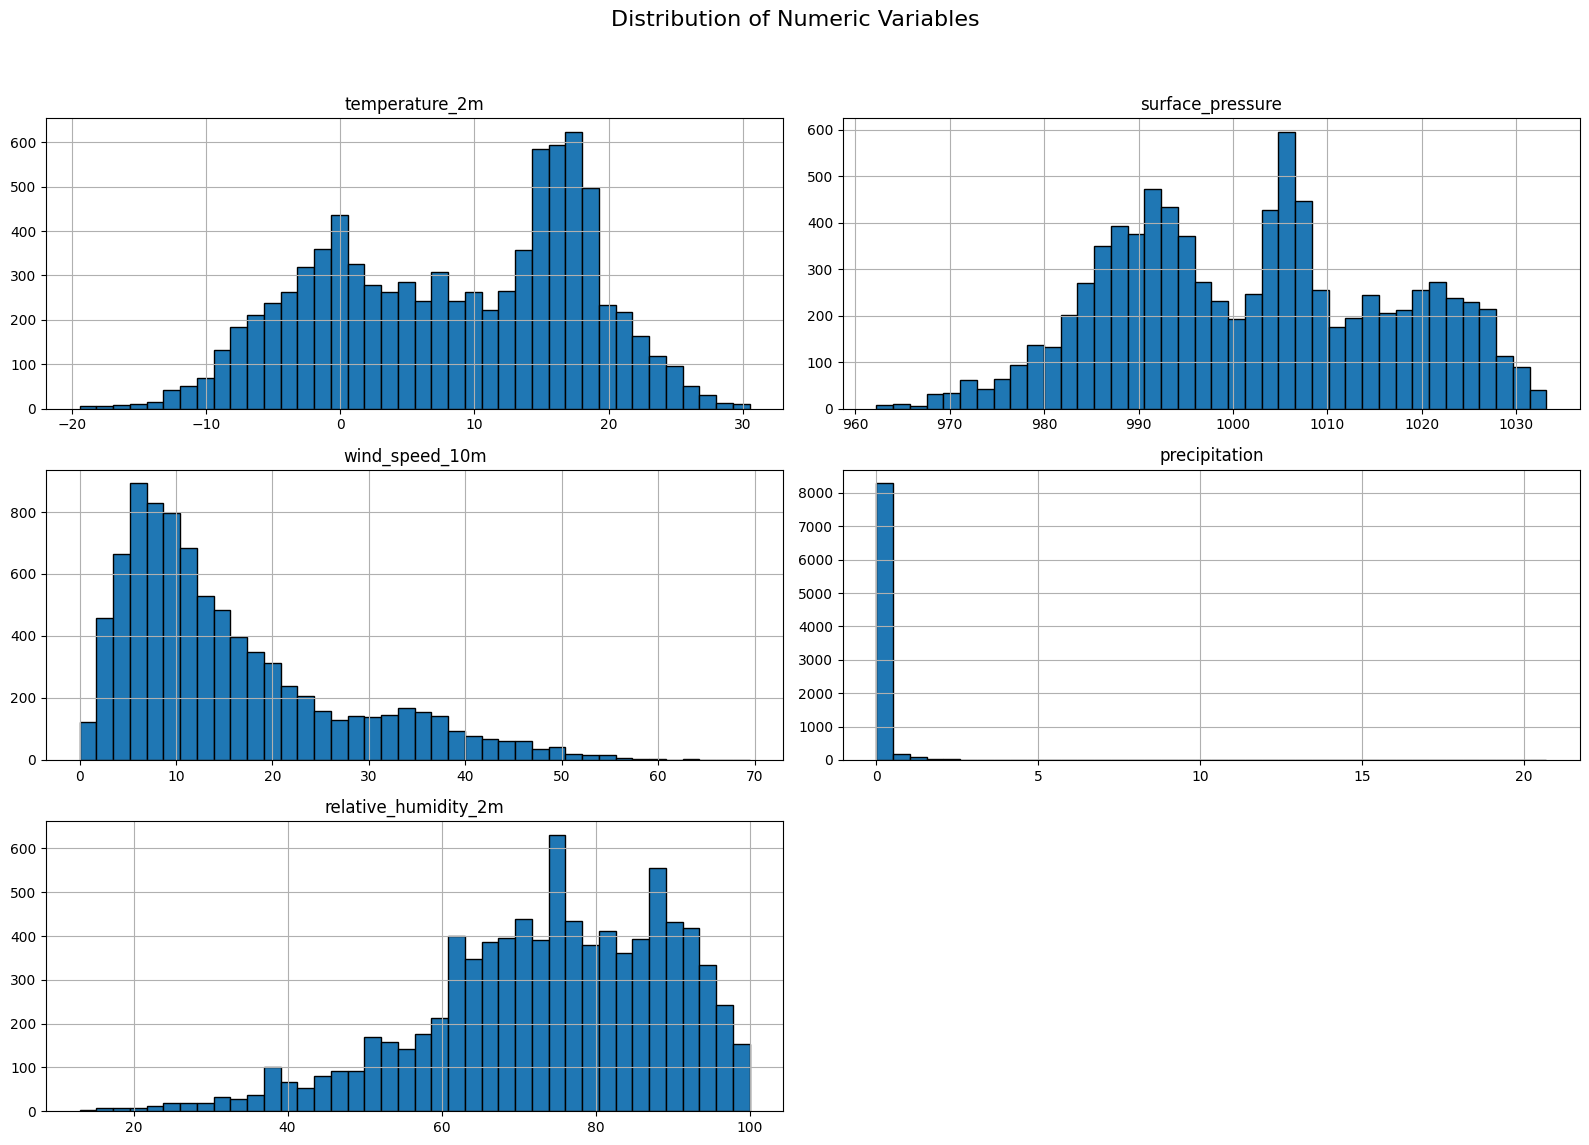

In [14]:
# Select numeric columns
numeric_cols = [
    'temperature_2m',
    'surface_pressure', 
    'wind_speed_10m',
    'precipitation',
    'relative_humidity_2m'
]

# Plot histograms
df[numeric_cols].hist(
    bins=40,
    figsize=(16, 12),
    edgecolor="black"
)

plt.suptitle("Distribution of Numeric Variables", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
#### Distributions and outliers of weather variables

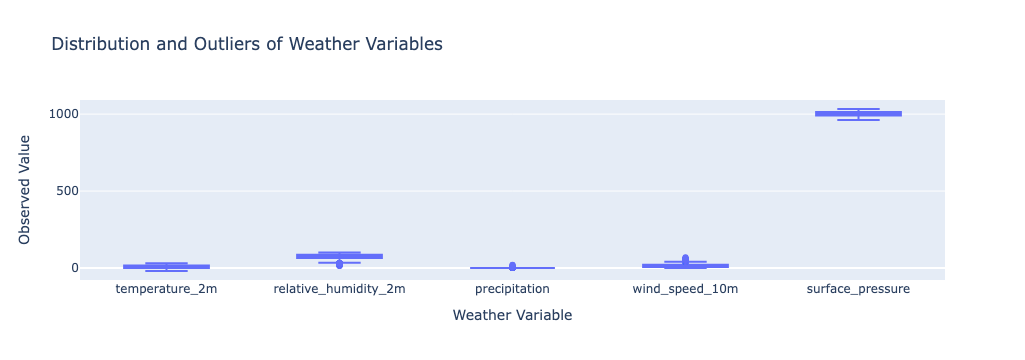

In [23]:
import plotly.express as px

# Select weather variables
weather_cols = ['temperature_2m','relative_humidity_2m','precipitation','wind_speed_10m','surface_pressure']

# Convert to long format
weather_long = df.melt(
    value_vars=weather_cols,
    var_name='Weather Variable',
    value_name='Measurement'
)

# Box plot
fig = px.box(
    weather_long,
    x='Weather Variable',
    y='Measurement',
    points='outliers',
    title='Distribution and Outliers of Weather Variables'
)

fig.update_layout(
    xaxis_title='Weather Variable',
    yaxis_title='Observed Value',
    showlegend=False
)

fig.show()


In [ ]:
#### Correlation s (Weather Variables)

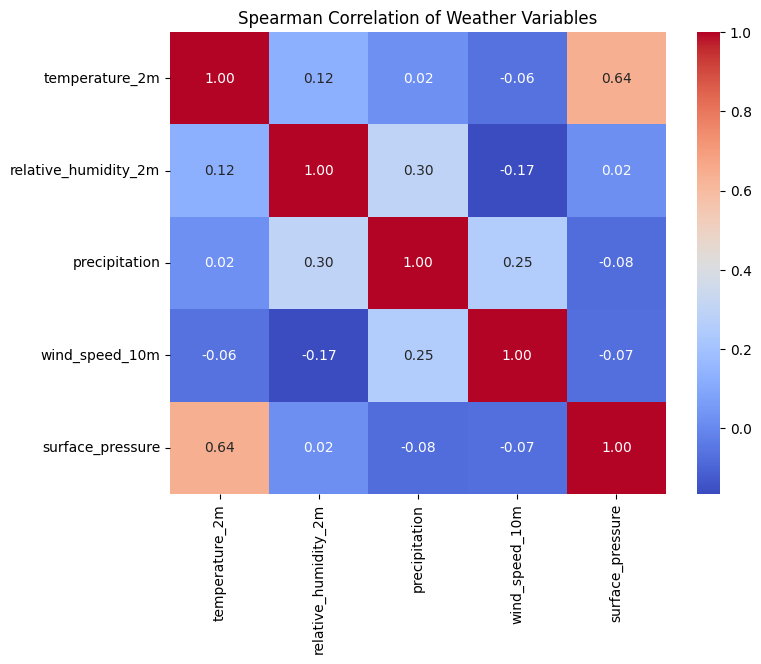

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Spearman correlation
corr_spearman = df[weather_vars].corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation of Weather Variables')
plt.show()



In [ ]:
#### Categorical EDA

In [35]:
df[weather_vars].corr(method="spearman")

,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,surface_pressure
temperature_2m,1.000000,0.124978,0.020874,-0.062811,0.643969
relative_humidity_2m,0.124978,1.000000,0.297431,-0.166125,0.020501
precipitation,0.020874,0.297431,1.000000,0.250597,-0.079457
wind_speed_10m,-0.062811,-0.166125,0.250597,1.000000,-0.074159
surface_pressure,0.643969,0.020501,-0.079457,-0.074159,1.000000
